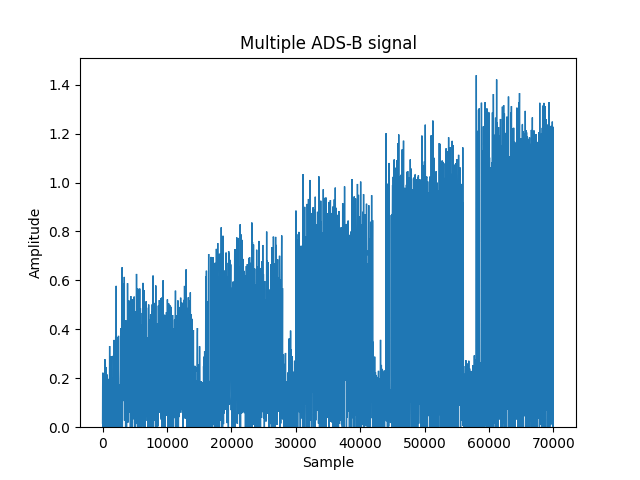

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import generate_ADSB_multiple, \
                                        digitize_signal, get_signal_energy, normalize_signal, \
                                        get_last_generated_signal_length, generate_approx, t_prescaler
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation
from approximations_list import Approximation, approximation_strings

data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits

multiple_signal_gaps = 200
signal_amount = 5
multiple_amplitudes = np.linspace(0.3, 1, signal_amount)

full_multiple_signal = generate_ADSB_multiple(multiple_amplitudes, full_bits)
full_multiple_signal_digitized, digitized_t = digitize_signal(full_multiple_signal, 100E6, 10E6, 1.4, 2**10)
one_signal_length = int(get_last_generated_signal_length()/t_prescaler)

plt.figure()
plt.stairs(full_multiple_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Multiple ADS-B signal')
plt.show()

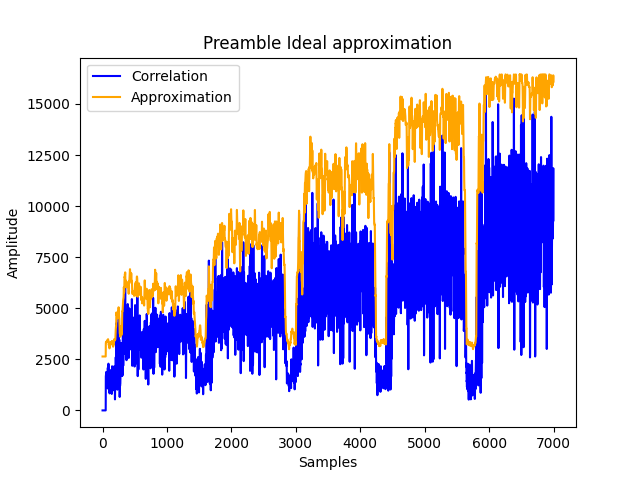

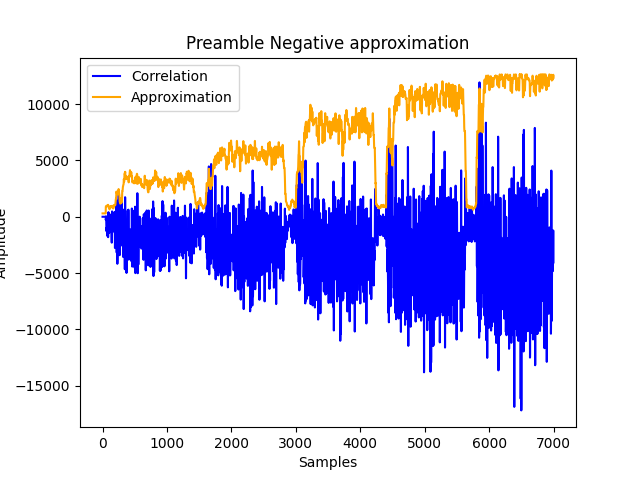

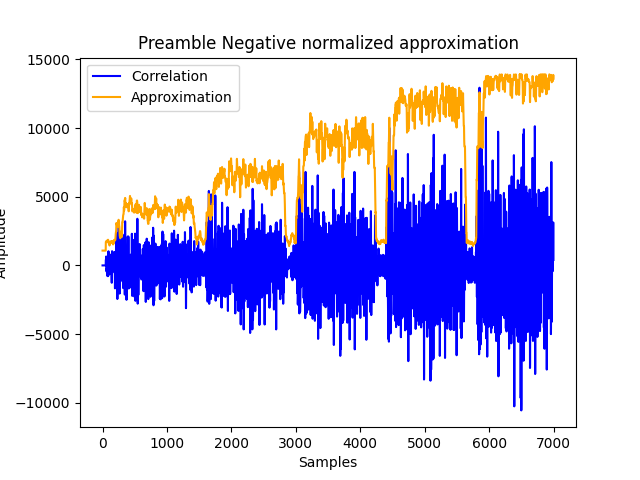

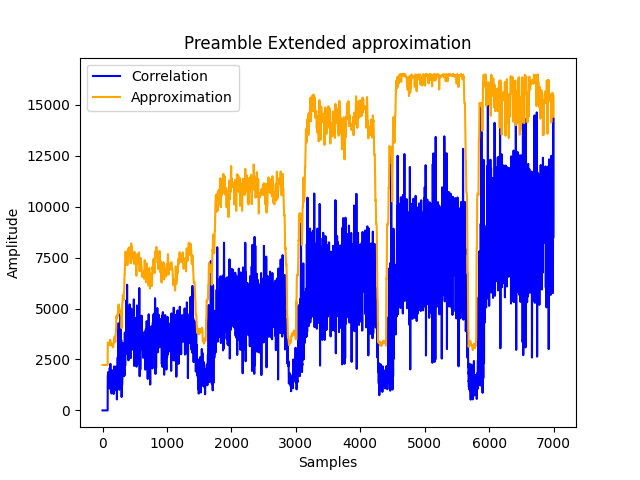

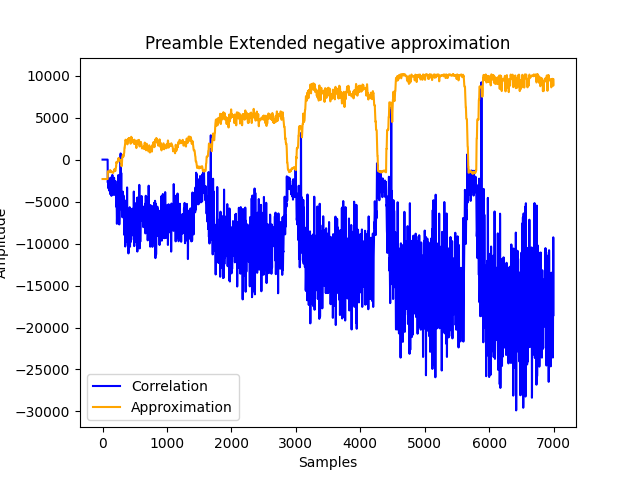

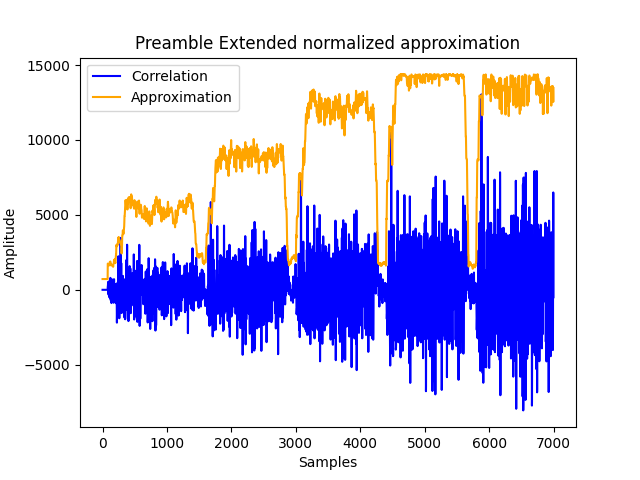

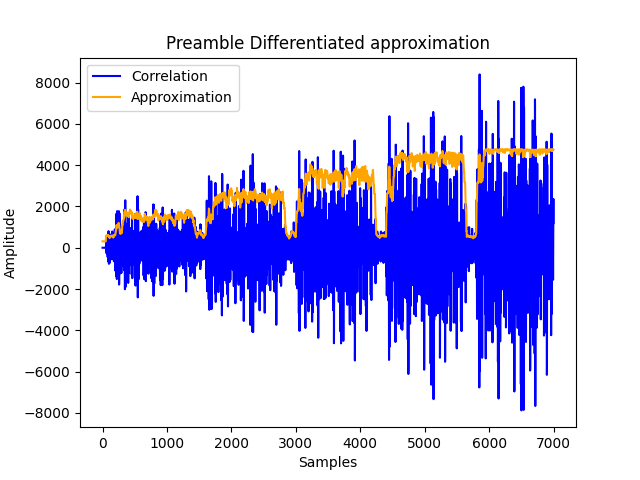

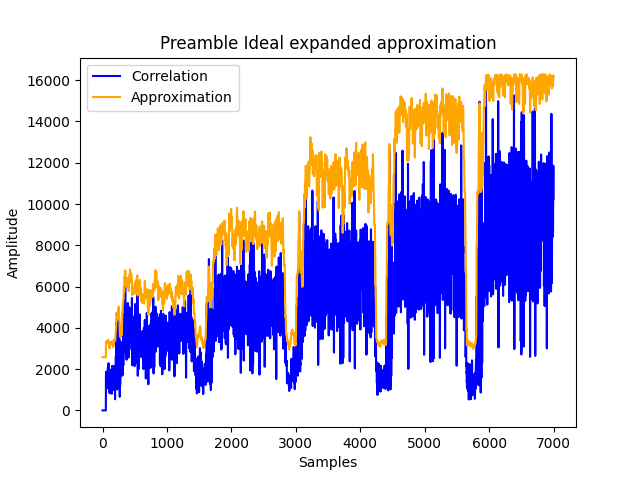

In [2]:
#Approximations
approx_data = np.load('python_approximations.npz')
loaded_poly_coeffs = approx_data['all_poly_coeffs'] #[preambule, approx, coefs]
approximation_type = Approximation.Mean.value

for preambule_i in range(len(preambule_list)):
    preamble = preambule_list[preambule_i]
    curr_preambule_corr = preamble.get_correlation(full_multiple_signal_digitized, Correlation.Basic)
    curr_energy = get_signal_energy(full_multiple_signal_digitized, len(preamble.get_coefficients()))
    curr_approx = generate_approx(curr_energy, loaded_poly_coeffs[preambule_i, approximation_type, :])
    max_idxs = np.zeros(signal_amount)
    max_values = np.zeros(signal_amount)
    preambule_ends = np.zeros(signal_amount)

    preamble_ends_values = np.zeros(signal_amount)
    for i in range(signal_amount):
        max_idxs[i] = np.argmax(curr_preambule_corr[i*one_signal_length : i*one_signal_length + one_signal_length]) + i * one_signal_length
        max_values[i] = curr_preambule_corr[int(max_idxs[i])]
        preambule_ends[i] = multiple_signal_gaps + preamble.get_expected_maximum() + i * one_signal_length
        preamble_ends_values[i] = curr_preambule_corr[int(preambule_ends[i])]

    # Plotting
    plt.figure()
    plt.plot(curr_preambule_corr, color="blue", label="Correlation")
    plt.plot(curr_approx, color="orange", label="Approximation")
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title("Preamble " + preambule_list[preambule_i].get_name() + " approximation")
    plt.legend()
    plt.show()